<a href="https://colab.research.google.com/github/margaretmz/GANs-in-Art-and-Design/blob/main/4_wgan_gp_anime_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

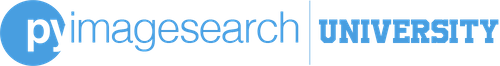

# WGAN-GP for Anime Faces
Author: Margaret Maynard-Reid ([@margaretmz](https://twitter.com/margaretmz))

This Colab notebook is a **Wasserstein GAN with Gradient Penality (WGAN-GP)** implementation with TensorFlow 2/ Keras, trained to generate 64x64 anime faces. It is associated with the [Anime Faces with WGAN and WGAN-GP](TODO) blog post published on 2022-02-07, as part of the [PyImageSearch University](https://www.pyimagesearch.com/pyimagesearch-university/) GAN series. 

I use comment `#UPDATE for WGAN-GP` to indicate all the changes needed to update from WGAN to WGAN-GP.

You may find all the GANs Colab notebooks in the author's GitHub repo [here](https://github.com/margaretmz/GANs-in-Art-and-Design).

Here are some helpful resources in case if you are unfamiliar with Jupyter notebooks or Colab:
*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). 
  
---  
  
**Copyright:**   
The content of this notebook is licensed under a [Creative Commons Attribution-NonCommercial 4.0](https://creativecommons.org/licenses/by-nc/4.0/) license, which means you are free to share and adapt the code, under the condition that you give appropriate credit to the author and you may not use it for commercial purposes.
  

Table of Contents

>[WGAN-GP for Anime Faces](#scrollTo=LgNY4Ko8sw7q)

>>[Import](#scrollTo=wcrOk6pURp50)

>>[Data](#scrollTo=Mhp9hUESy46A)

>>>[Visualization](#scrollTo=PFE71AWEDZBp)

>>>[Preprocessing](#scrollTo=Eo818wWbDY7S)

>>[The Generator](#scrollTo=BY-sz-IFbWr7)

>>[The Critic](#scrollTo=9qAUg0qNbXpS)

>>[WGAN-GP](#scrollTo=X0IOiEj-QNXd)

>>[Use Keras Callback to monitor training](#scrollTo=QtlnNc4lQw53)

>>[Compile and Train WGAN-GP](#scrollTo=9OubidSS_Lrl)

>>>[Putting together the wgan-gp model](#scrollTo=FzjTO5ZqRLVY)

>>>[Wasserstein loss](#scrollTo=t8aze5HsCzfU)

>>>[Compile WGAN-GP](#scrollTo=X8ImZUxjC7Ni)

>>>[Train WGAN-GP](#scrollTo=1WhnM4ptN2rp)



## Import

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

Its always a good practice to check the current version of TensorFlow...

In [ ]:
print(tf.version.VERSION)

2.7.0


## Data

We will train the WGAN-GP on a dataset called [Anime Faces](https://www.kaggle.com/splcher/animefacedataset) from Kaggle, which a collection of anime faces scraped from www.getchu.com

Here is how to download Kaggle data from Colab:
* Navigate to https://www.kaggle.com. 
* Go to the [account tab](https://www.kaggle.com/me/account)  of your user profile. 
* Select "Create API Token" which triggers the download of kaggle.json, a file containing your API credentials. 
* Enter your username and Kaggle key in the cell below.

In [ ]:
os.environ['KAGGLE_USERNAME']="enter-your-own-user-name" 
os.environ['KAGGLE_KEY']="enter-your-own-kaggle-key"

In [ ]:
# download kaggle dataset to 'datasets/' path
!kaggle datasets download -d splcher/animefacedataset -p datasets

 96% 377M/395M [00:07<00:00, 36.3MB/s]
100% 395M/395M [00:07<00:00, 51.9MB/s]


In [ ]:
!unzip datasets/animefacedataset.zip -d datasets/

In [ ]:
anime_data_dir = "/content/datasets/images"

In [ ]:
train_images = tf.keras.utils.image_dataset_from_directory(
    anime_data_dir, label_mode=None, image_size=(64, 64), batch_size=256 # Margaret: increase batch size from 32 
)

Found 63565 files belonging to 1 classes.


### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

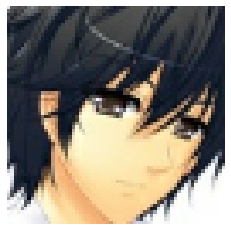

In [ ]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")

# Visualize 1 random image from the training dataset
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [ ]:
def show(images):
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = keras.utils.array_to_img(images[i]) 
        plt.imshow(img)
        plt.axis('off') 
    plt.show()

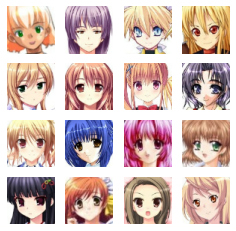

In [ ]:
# Visualize 16 images from the training dataset
show(image_batch[:16])

### Preprocessing

In [ ]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images: we feed random noise as input to the generator and upsample it till the desired image size becomes 64x64x3.

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 128
# weight initializer for G per DCGAN paper 
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 

In [ ]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), 
                                     strides=(2, 2),
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) 
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), 
                                     strides=(2, 2),
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) 
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), 
                                     strides=(2, 2),
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) 
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
# build the generator model
generator = build_generator() 

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097152   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0 

## The Critic



In [ ]:
# UPDATE for WGAN-GP: no more weight clipping
# class WeightClip(tf.keras.constraints.Constraint):
#     def __init__(self, clip_value):
#         self.clip_value = clip_value
    
#     def __call__(self, weights):
#         return tf.clip_by_value(weights, -self.clip_value, self.clip_value)
    
#     def get_config(self):
#         return {'clip_value': self.clip_value}

Define the Critic model architecture with the Keras `Sequential` API

In [ ]:
def build_critic(height, width, depth, alpha=0.2):
    # Weight clipping to [-1, 1] to enfoce 1-Lipschitz constraint
    # constraint = WeightClip(0.01) # UPDATE for WGAN-GP: remove weight clipping

    # create a Keras Sequential model
    model = Sequential(name="critic")
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), 
                            padding="same", 
                            strides=(2, 2), 
                            # kernel_constraint = constraint, # UPDATE for WGAN-GP: remove weight clipping
                            input_shape=input_shape))
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), 
                            padding="same", 
                            strides=(2, 2))) 
                            # kernel_constraint = constraint,)) # UPDATE for WGAN-GP: remove weight clipping
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), 
                            padding="same", 
                            strides=(2, 2))) 
                            # kernel_constraint = constraint,)) # UPDATE for WGAN-GP: remove weight clipping
    # model.add(layers.BatchNormalization()) # UPDATE for WGAN-GP: remove batchnorm
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)) 

    # linear activation in the last layer 
    # Note: Keras `Dense` layer by default is already a `linear` activation
    model.add(layers.Dense(1, activation="linear"))

    # return the critic model
    return model

In [ ]:
# build the critic model
critic = build_critic(64, 64, 3) 

In [ ]:
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0    

## WGAN-GP

Subclass `keras.Model` to implement WGAN-GP and override `train_step()` to implement custom training steps for training the critic and generator in WGAN-GP.

In [ ]:
class WGAN_GP(keras.Model):
    def __init__(self, 
                 critic, 
                 generator, 
                 latent_dim, 
                 critic_extra_steps, 
                 gp_weight=10.0): # UPDATE for WGAN-GP: gradient penalty weight
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.gp_weight = gp_weight # WGAN-GP
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")


    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # UPDATE for WGAN-GP: use gradient penalty instead of weight clipping
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        Gradient penalty is calculated on an interpolated image
        and added to the discriminator loss.
        """
        
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        # 1. Create the interpolated image
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 2. Get the Critic's output for the interpolated image
            pred = self.critic(interpolated, training=True)

        # 3. Calculate the gradients w.r.t to the interpolated image
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 4. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        # 5. Calculate gradient penalty
        gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
        return gradient_penalty

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the critic more often than the generator by 5 times (self.c_extra_steps) 
        for i in range(self.c_extra_steps):
            # Step 1. Train the critic with both real images and fake images
            with tf.GradientTape() as tape:
                pred_real = self.critic(real_images, training=True)
                fake_images = self.generator(noise, training=True) 
                pred_fake = self.critic(fake_images, training=True)
                # UPDATE for WGAN-GP: Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # UPDATE for WGAN-GP: Add gradient penalty to the original critic loss 
                d_loss = self.d_loss_fn(pred_real, pred_fake) + gp * self.gp_weight 
            # Compute critic gradients
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            # Update critic weights
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Step 2. Train the generator (do not update weights of the critic)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Use Keras Callback to monitor training

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our WGAN-GP training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Compile and Train WGAN-GP

Compile the `wgan-gp` model, use the `Adam` optimizer as recommended by the WGAN-GP paper, and the Wasserstein loss same as in WGAN.

### Putting together the `wgan-gp` model

In [ ]:
wgan_gp = WGAN_GP(critic=critic, 
              generator=generator, 
              latent_dim=LATENT_DIM,
              critic_extra_steps=5) 

### Wasserstein loss

In [ ]:
# Wasserstein loss for the critic
def d_wasserstein_loss(pred_real, pred_fake):
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for the generator
def g_wasserstein_loss(pred_fake):
    return -tf.reduce_mean(pred_fake)

### Compile WGAN-GP

In [ ]:
LR = 0.0002 # WGAN-GP paper recommends lr of 0.0002
d_optimizer = keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.9) # UPDATE for WGAN-GP: use Adam instead of RMSProp
g_optimizer = keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.9) # UPDATE for WGAN-GP: use Adam instead of RMSProp

In [ ]:
wgan_gp.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,  
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

### Train WGAN-GP
Now we simply call `model.fit()` to traing the `wgan-gp` model!

Epoch 1/50
249/249 [==============================] - ETA: 0s - d_loss: -25.8944 - g_loss: 16.5887

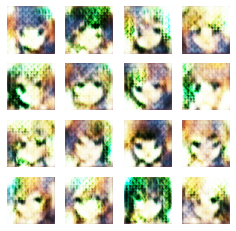

249/249 [==============================] - 130s 457ms/step - d_loss: -25.8944 - g_loss: 16.5887
Epoch 2/50
249/249 [==============================] - ETA: 0s - d_loss: -12.4690 - g_loss: -20.9456

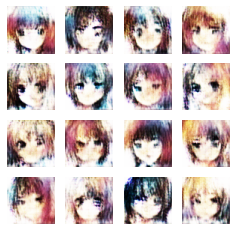

249/249 [==============================] - 114s 456ms/step - d_loss: -12.4690 - g_loss: -20.9456
Epoch 3/50
249/249 [==============================] - ETA: 0s - d_loss: -9.0953 - g_loss: -47.6483

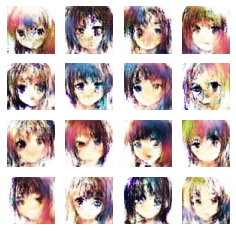

249/249 [==============================] - 114s 455ms/step - d_loss: -9.0953 - g_loss: -47.6483
Epoch 4/50
249/249 [==============================] - ETA: 0s - d_loss: -7.8578 - g_loss: -25.7022

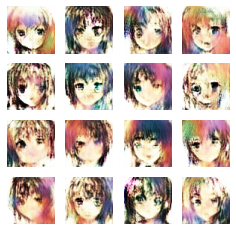

249/249 [==============================] - 114s 455ms/step - d_loss: -7.8578 - g_loss: -25.7022
Epoch 5/50
249/249 [==============================] - ETA: 0s - d_loss: -7.0476 - g_loss: -14.2068

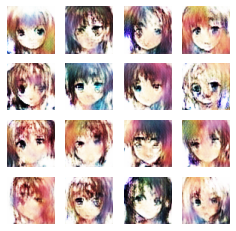

249/249 [==============================] - 114s 455ms/step - d_loss: -7.0476 - g_loss: -14.2068
Epoch 6/50
249/249 [==============================] - ETA: 0s - d_loss: -6.2802 - g_loss: -10.6986

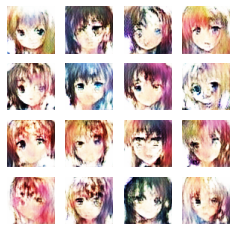

249/249 [==============================] - 114s 455ms/step - d_loss: -6.2802 - g_loss: -10.6986
Epoch 7/50
249/249 [==============================] - ETA: 0s - d_loss: -5.9455 - g_loss: -14.5044

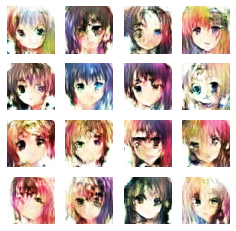

249/249 [==============================] - 113s 455ms/step - d_loss: -5.9455 - g_loss: -14.5044
Epoch 8/50
249/249 [==============================] - ETA: 0s - d_loss: -5.4866 - g_loss: -10.2339

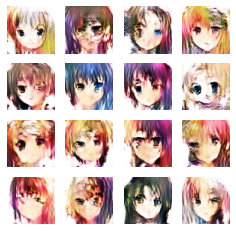

249/249 [==============================] - 113s 454ms/step - d_loss: -5.4866 - g_loss: -10.2339
Epoch 9/50
249/249 [==============================] - ETA: 0s - d_loss: -5.4754 - g_loss: -11.2963

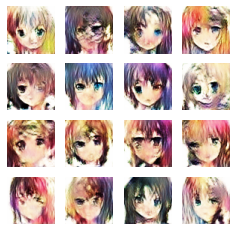

249/249 [==============================] - 113s 454ms/step - d_loss: -5.4754 - g_loss: -11.2963
Epoch 10/50
249/249 [==============================] - ETA: 0s - d_loss: -5.1044 - g_loss: 15.7027

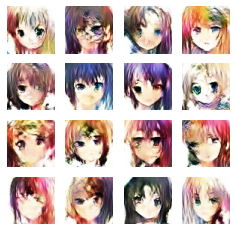

249/249 [==============================] - 114s 455ms/step - d_loss: -5.1044 - g_loss: 15.7027
Epoch 11/50
249/249 [==============================] - ETA: 0s - d_loss: -5.0211 - g_loss: 7.8357

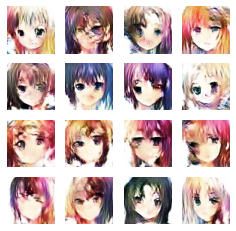

249/249 [==============================] - 113s 454ms/step - d_loss: -5.0211 - g_loss: 7.8357
Epoch 12/50
249/249 [==============================] - ETA: 0s - d_loss: -4.6237 - g_loss: 21.7232

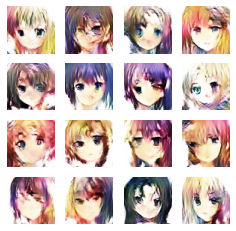

249/249 [==============================] - 113s 454ms/step - d_loss: -4.6237 - g_loss: 21.7232
Epoch 13/50
249/249 [==============================] - ETA: 0s - d_loss: -5.1454 - g_loss: 42.1834

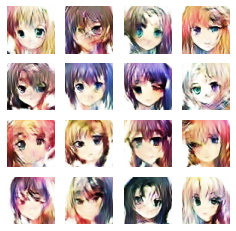

249/249 [==============================] - 113s 454ms/step - d_loss: -5.1454 - g_loss: 42.1834
Epoch 14/50
249/249 [==============================] - ETA: 0s - d_loss: -5.2177 - g_loss: -6.5478

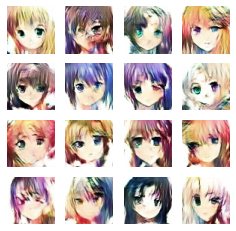

249/249 [==============================] - 114s 456ms/step - d_loss: -5.2177 - g_loss: -6.5478
Epoch 15/50
249/249 [==============================] - ETA: 0s - d_loss: -4.5311 - g_loss: 38.6666

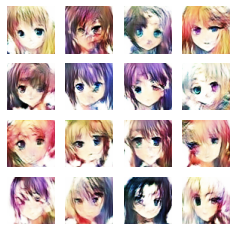

249/249 [==============================] - 113s 454ms/step - d_loss: -4.5311 - g_loss: 38.6666
Epoch 16/50
249/249 [==============================] - ETA: 0s - d_loss: -4.2036 - g_loss: 13.7912

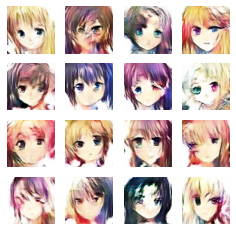

249/249 [==============================] - 113s 454ms/step - d_loss: -4.2036 - g_loss: 13.7912
Epoch 17/50
249/249 [==============================] - ETA: 0s - d_loss: -4.1467 - g_loss: 25.7378

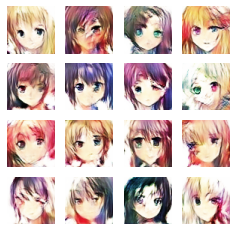

249/249 [==============================] - 113s 454ms/step - d_loss: -4.1467 - g_loss: 25.7378
Epoch 18/50
249/249 [==============================] - ETA: 0s - d_loss: -4.1034 - g_loss: 24.8653

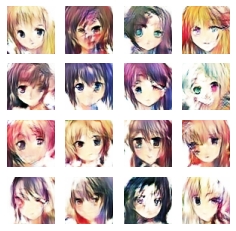

249/249 [==============================] - 114s 455ms/step - d_loss: -4.1034 - g_loss: 24.8653
Epoch 19/50
249/249 [==============================] - ETA: 0s - d_loss: -3.8550 - g_loss: 25.1214

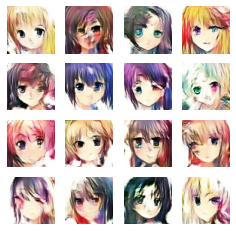

249/249 [==============================] - 113s 455ms/step - d_loss: -3.8550 - g_loss: 25.1214
Epoch 20/50
249/249 [==============================] - ETA: 0s - d_loss: -3.6135 - g_loss: 6.0896

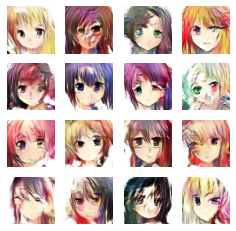

249/249 [==============================] - 113s 454ms/step - d_loss: -3.6135 - g_loss: 6.0896
Epoch 21/50
249/249 [==============================] - ETA: 0s - d_loss: -3.6915 - g_loss: 46.9775

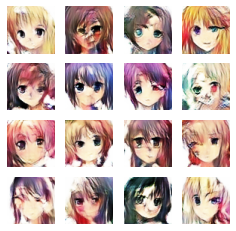

249/249 [==============================] - 113s 454ms/step - d_loss: -3.6915 - g_loss: 46.9775
Epoch 22/50
249/249 [==============================] - ETA: 0s - d_loss: -3.5917 - g_loss: 17.9169

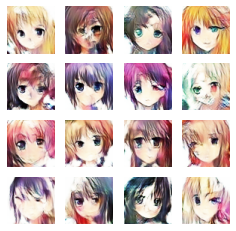

249/249 [==============================] - 114s 455ms/step - d_loss: -3.5917 - g_loss: 17.9169
Epoch 23/50
249/249 [==============================] - ETA: 0s - d_loss: -3.4257 - g_loss: -9.3810

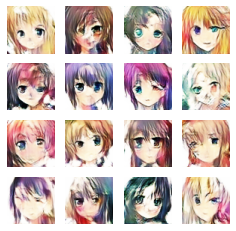

249/249 [==============================] - 113s 454ms/step - d_loss: -3.4257 - g_loss: -9.3810
Epoch 24/50
249/249 [==============================] - ETA: 0s - d_loss: -3.2850 - g_loss: 10.1361

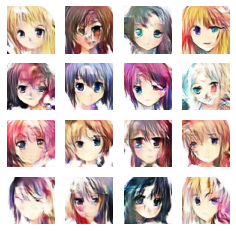

249/249 [==============================] - 113s 454ms/step - d_loss: -3.2850 - g_loss: 10.1361
Epoch 25/50
249/249 [==============================] - ETA: 0s - d_loss: -3.2808 - g_loss: -7.2804

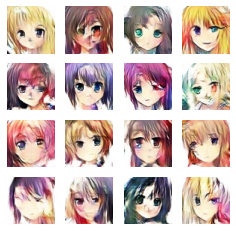

249/249 [==============================] - 113s 454ms/step - d_loss: -3.2808 - g_loss: -7.2804
Epoch 26/50
249/249 [==============================] - ETA: 0s - d_loss: -3.1208 - g_loss: -14.7814

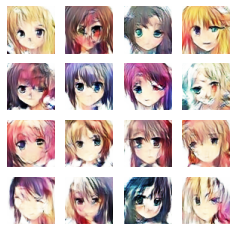

249/249 [==============================] - 114s 455ms/step - d_loss: -3.1208 - g_loss: -14.7814
Epoch 27/50
249/249 [==============================] - ETA: 0s - d_loss: -3.1138 - g_loss: 11.1928

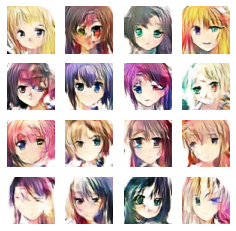

249/249 [==============================] - 113s 454ms/step - d_loss: -3.1138 - g_loss: 11.1928
Epoch 28/50
249/249 [==============================] - ETA: 0s - d_loss: -3.1647 - g_loss: 60.6347

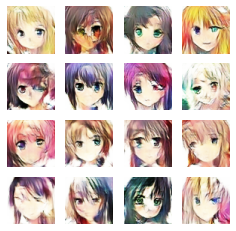

249/249 [==============================] - 113s 454ms/step - d_loss: -3.1647 - g_loss: 60.6347
Epoch 29/50
249/249 [==============================] - ETA: 0s - d_loss: -3.0223 - g_loss: 40.1166

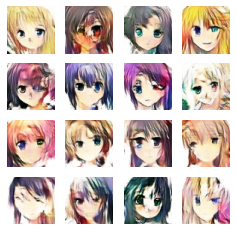

249/249 [==============================] - 113s 454ms/step - d_loss: -3.0223 - g_loss: 40.1166
Epoch 30/50
249/249 [==============================] - ETA: 0s - d_loss: -2.8719 - g_loss: 8.5710

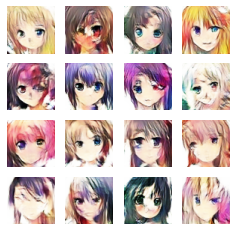

249/249 [==============================] - 114s 455ms/step - d_loss: -2.8719 - g_loss: 8.5710
Epoch 31/50
249/249 [==============================] - ETA: 0s - d_loss: -2.9049 - g_loss: -39.5678

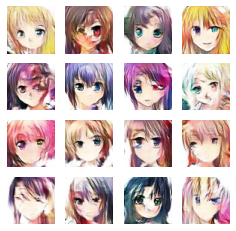

249/249 [==============================] - 113s 455ms/step - d_loss: -2.9049 - g_loss: -39.5678
Epoch 32/50
249/249 [==============================] - ETA: 0s - d_loss: -2.7387 - g_loss: -20.0349

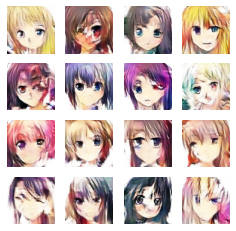

249/249 [==============================] - 113s 455ms/step - d_loss: -2.7387 - g_loss: -20.0349
Epoch 33/50
249/249 [==============================] - ETA: 0s - d_loss: -2.7493 - g_loss: 20.9850

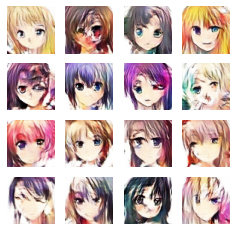

249/249 [==============================] - 113s 455ms/step - d_loss: -2.7493 - g_loss: 20.9850
Epoch 34/50
249/249 [==============================] - ETA: 0s - d_loss: -2.7882 - g_loss: 38.6871

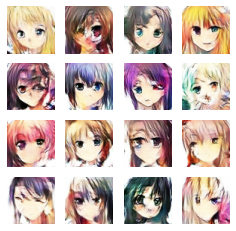

249/249 [==============================] - 114s 455ms/step - d_loss: -2.7882 - g_loss: 38.6871
Epoch 35/50
249/249 [==============================] - ETA: 0s - d_loss: -2.7081 - g_loss: 58.6398

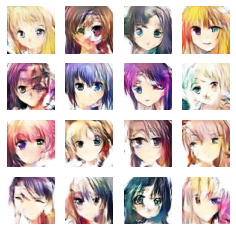

249/249 [==============================] - 113s 454ms/step - d_loss: -2.7081 - g_loss: 58.6398
Epoch 36/50
249/249 [==============================] - ETA: 0s - d_loss: -2.3960 - g_loss: -106.6233

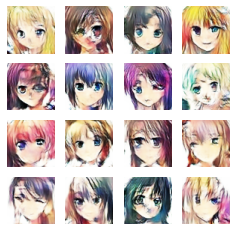

249/249 [==============================] - 113s 454ms/step - d_loss: -2.3960 - g_loss: -106.6233
Epoch 37/50
249/249 [==============================] - ETA: 0s - d_loss: -2.5270 - g_loss: -55.7086

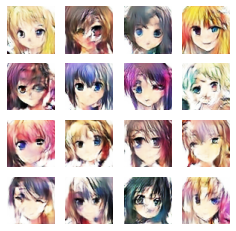

249/249 [==============================] - 113s 454ms/step - d_loss: -2.5270 - g_loss: -55.7086
Epoch 38/50
249/249 [==============================] - ETA: 0s - d_loss: -2.4367 - g_loss: 153.3468

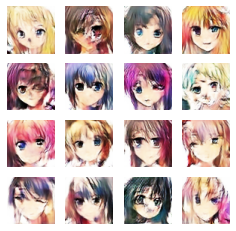

249/249 [==============================] - 114s 455ms/step - d_loss: -2.4367 - g_loss: 153.3468
Epoch 39/50
249/249 [==============================] - ETA: 0s - d_loss: -2.2058 - g_loss: 13.2495

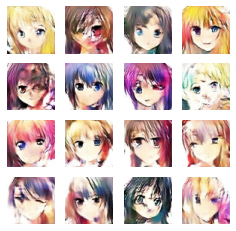

249/249 [==============================] - 113s 454ms/step - d_loss: -2.2058 - g_loss: 13.2495
Epoch 40/50
249/249 [==============================] - ETA: 0s - d_loss: -2.3011 - g_loss: -120.0288

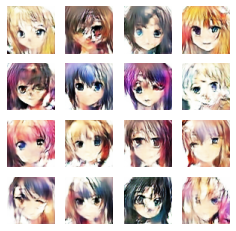

249/249 [==============================] - 113s 454ms/step - d_loss: -2.3011 - g_loss: -120.0288
Epoch 41/50
249/249 [==============================] - ETA: 0s - d_loss: -1.7327 - g_loss: -165.8768

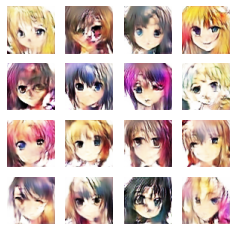

249/249 [==============================] - 113s 454ms/step - d_loss: -1.7327 - g_loss: -165.8768
Epoch 42/50
249/249 [==============================] - ETA: 0s - d_loss: -1.7799 - g_loss: -106.7739

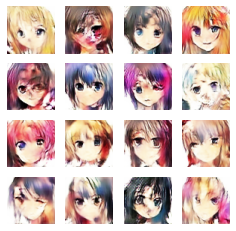

249/249 [==============================] - 114s 455ms/step - d_loss: -1.7799 - g_loss: -106.7739
Epoch 43/50
249/249 [==============================] - ETA: 0s - d_loss: -1.6299 - g_loss: -208.8478

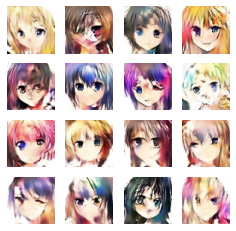

249/249 [==============================] - 113s 454ms/step - d_loss: -1.6299 - g_loss: -208.8478
Epoch 44/50
249/249 [==============================] - ETA: 0s - d_loss: -1.9656 - g_loss: 38.7996

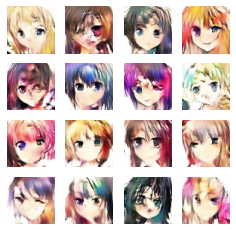

249/249 [==============================] - 113s 454ms/step - d_loss: -1.9656 - g_loss: 38.7996
Epoch 45/50
249/249 [==============================] - ETA: 0s - d_loss: -1.8439 - g_loss: 226.0941

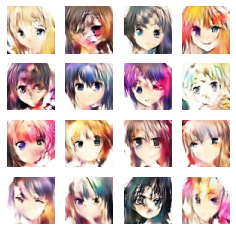

249/249 [==============================] - 113s 454ms/step - d_loss: -1.8439 - g_loss: 226.0941
Epoch 46/50
249/249 [==============================] - ETA: 0s - d_loss: -2.1797 - g_loss: 315.3703

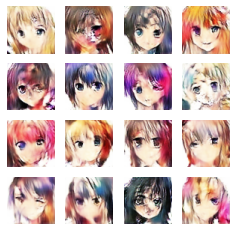

249/249 [==============================] - 114s 455ms/step - d_loss: -2.1797 - g_loss: 315.3703
Epoch 47/50
249/249 [==============================] - ETA: 0s - d_loss: -1.6011 - g_loss: 446.7436

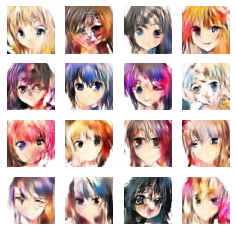

249/249 [==============================] - 113s 454ms/step - d_loss: -1.6011 - g_loss: 446.7436
Epoch 48/50
249/249 [==============================] - ETA: 0s - d_loss: -1.8256 - g_loss: 247.0610

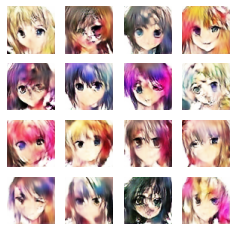

249/249 [==============================] - 113s 454ms/step - d_loss: -1.8256 - g_loss: 247.0610
Epoch 49/50
249/249 [==============================] - ETA: 0s - d_loss: -1.5105 - g_loss: 252.7459

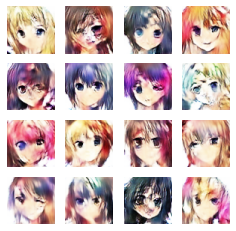

249/249 [==============================] - 113s 454ms/step - d_loss: -1.5105 - g_loss: 252.7459
Epoch 50/50
249/249 [==============================] - ETA: 0s - d_loss: -2.3636 - g_loss: 291.6182

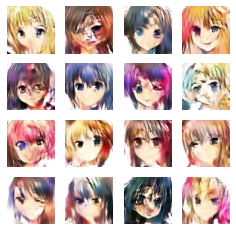

249/249 [==============================] - 114s 455ms/step - d_loss: -2.3636 - g_loss: 291.6182


In [ ]:
NUM_EPOCHS = 50 # number of epochs
wgan_gp.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])